## **Marketing Final Project (Individual)**

**Name: Nilesh Kokulwar**

**ID: 0852117**

#### Aim:
#### **To create a data-driven marketing analysis on Walmart that incorporates multiple dimensions such as price categorization, churn analysis, product performance, and strategic insights like SWOT analysis.**

#### The ultimate goal is to extract actionable insights, optimize marketing strategies, and present a holistic view of **Walmart**'s product offerings and customer engagement.

In [112]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [113]:
df = pd.read_excel('Walmart_CA_MergedFiles.xlsx')
df.head()

,website,country,Category,Sub_category,main_url,Page,usItemId,name,brand,breadcrum,...,Rating,Review,mediaRating,sellerId,sellerName,productLocation,isPreOrder,manufacturerName,cachepage_path,datetime
0,Walmart,CA,Clothing,Women,https://www.walmart.ca/en/browse/clothing-shoe...,1,"""6000207947262",George Plus Women's Crew Neckline Nightshirt,George,"Clothing, Shoes & Accessories || Women || Wome...",...,5.0000,1,NaN,"""0",Walmart,NaN,False,NaN,C:\prarthavi\Sem3-st clair\Marketing\Final Pro...,2024-11-10 14:30:29.648
1,Walmart,CA,Clothing,Women,https://www.walmart.ca/en/browse/clothing-shoe...,1,"""6000207947167","George Women's Crew Neckline Nightshirt, Sizes...",George,"Clothing, Shoes & Accessories || Women || Wome...",...,4.8750,8,NaN,"""0",Walmart,NaN,False,NaN,C:\prarthavi\Sem3-st clair\Marketing\Final Pro...,2024-11-10 14:30:29.648
2,Walmart,CA,Clothing,Women,https://www.walmart.ca/en/browse/clothing-shoe...,1,"""6000198484490","Secret® Freedom Plus Blackout Tights 1pk, Size...",Secret,"Clothing, Shoes & Accessories || Women || Wome...",...,4.4615,13,NaN,"""0",Walmart,NaN,False,NaN,C:\prarthavi\Sem3-st clair\Marketing\Final Pro...,2024-11-10 14:30:29.648
3,Walmart,CA,Clothing,Women,https://www.walmart.ca/en/browse/clothing-shoe...,1,"""6000208027730","George Plus Women's Plush Sleep Pant, Sizes 1X-4X",George,"Clothing, Shoes & Accessories || Women || Wome...",...,0.0000,0,NaN,"""0",Walmart,NaN,False,NaN,C:\prarthavi\Sem3-st clair\Marketing\Final Pro...,2024-11-10 14:30:29.648
4,Walmart,CA,Clothing,Women,https://www.walmart.ca/en/browse/clothing-shoe...,1,"""6000203950677","Secret Seamless Shaping Mid Thigh 1pk, Sizes: ...",Secret,"Clothing, Shoes & Accessories || Women || Wome...",...,3.6000,5,NaN,"""0",Walmart,NaN,False,NaN,C:\prarthavi\Sem3-st clair\Marketing\Final Pro...,2024-11-10 14:30:29.648


## **Data Cleaning and Preparation**

In [114]:
# finding missing values
df.isnull().sum()

website                       0
country                       0
Category                      0
Sub_category                  0
main_url                      0
Page                          0
usItemId                      0
name                          0
brand                         0
breadcrum                     0
product_url                   0
current_price               121
original_price              121
discount                      0
unit_price                19300
stock_condition               0
canAddToCart                  0
subscriptionEligible          0
isSponsoredFlag               0
fulfillmentBadges           111
returnable                    0
returnable_period           335
returnable_period_type      335
badges                        0
Rating                        8
Review                        0
mediaRating               25340
sellerId                      0
sellerName                  107
productLocation           25340
isPreOrder                    0
manufact

In [115]:
df.rename(columns={'name': 'product_name'}, inplace=True)

In [116]:
#Improved encoding handling for the 'name' column
df['product_name'] = df['product_name'].astype(str).str.encode('utf-8', errors='replace').str.decode('utf-8')

#Further cleaning to remove any remaining problematic characters
df['product_name'] = df['product_name'].str.replace(r'[^\x00-\x7F]+', '', regex=True)

In [117]:
df['product_name'].head()

0         George Plus Women's Crew Neckline Nightshirt
1    George Women's Crew Neckline Nightshirt, Sizes...
2    Secret Freedom Plus Blackout Tights 1pk, Sizes...
3    George Plus Women's Plush Sleep Pant, Sizes 1X-4X
4    Secret Seamless Shaping Mid Thigh 1pk, Sizes: ...
Name: product_name, dtype: object

In [118]:
# droping off columns that will not impact the analysis directly or indirectly.
columns_to_drop = ["mediaRating", "productLocation", "cachepage_path", "main_url", 'sellerId', 'Page']
df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

In [119]:
# Converting all price related column to numeric values
price_columns = ["current_price", "original_price", "unit_price"]
for col in price_columns:
    df[col] = pd.to_numeric(
        df[col].replace(r"[^\d.]", "", regex=True), errors="coerce"
    )

In [120]:
df = df.drop(df[(df['current_price'].isna()) & (df['stock_condition'] == 'in stock')].index)

In [121]:
# Updated 'current_price' and 'original_price' to 0 where 'stock_condition' was 'out of stock'
df.loc[
    (df['stock_condition'] == 'out of stock') & (df['current_price'].isna()),
    ['current_price', 'original_price']
] = 0

In [122]:
df['returnable_period'].fillna(0, inplace=True)
df['returnable_period'].unique()

array([ 90.,   0.,  30., 120.])

In [123]:
df['returnable_period_type'].fillna('Day', inplace=True)
df['returnable_period_type'].unique()

array(['Day'], dtype=object)

In [124]:
df['sellerName'].fillna('NA', inplace=True)

In [125]:
df['manufacturerName'].fillna('NA', inplace=True)

In [126]:
df['fulfillmentBadges'].replace('[]', 'NA', inplace=True)
df['fulfillmentBadges'].fillna('NA', inplace=True)

### Feature Engineering

In [127]:
#Replacing the null values of Rating column with Median of the whole column
df['Rating'] = df['Rating'].fillna(df.groupby('Category')['Rating'].transform('median'))
df.dropna(subset=['current_price', 'original_price'], inplace=True)

In [128]:
df['discount_percentage'] = ((df['original_price'] - df['current_price']) / df['original_price']) * 100
df['discount_percentage'].isnull().sum()

109

In [129]:
df['discount_percentage'] = df['discount_percentage'].fillna(0)

In [130]:
df['discount_percentage'].round(2).tail(2)

25338     0.00
25339    13.91
Name: discount_percentage, dtype: float64

In [131]:
# Creating time-based features

df['datetime'] = pd.to_datetime(df['datetime'])
df['month'] = df['datetime'].dt.month
df['day_of_week'] = df['datetime'].dt.dayofweek

In [132]:
low_threshold = df['current_price'].quantile(0.33)
mid_threshold = df['current_price'].quantile(0.66)

# Created a new 'price_category' feature

def price_category(price):
    if price <= low_threshold:
        return 'low-cost'
    elif price <= mid_threshold:
        return 'mid-range'
    else:
        return 'premium'

df['price_category'] = df['current_price'].apply(price_category)


print(df[['current_price', 'price_category']].head())

   current_price price_category
0          12.00      mid-range
1          12.00      mid-range
2          15.97      mid-range
3          12.00      mid-range
4          22.97        premium


### **Exploratory Data Analysis**

#### **Analyzing Trends:**

1. Identifying top-performing categories, brands, and products.
2. Analyzing average discounts and their effect on ratings and reviews.

In [133]:
# High-demand products

df['high_demand'] = (df['Rating'] > 4) & (df['Review'] > 11)
df['high_demand'].unique()

array([False,  True])

In [134]:
# Top-performing categories
category_performance = df.groupby('Category').agg({
    'Rating': 'mean',
    'Review': 'sum',
    'current_price': 'mean'
}).sort_values(by='Review', ascending=False)

In [135]:
category_performance

,Rating,Review,current_price
Category,,,
Beauty,3.319986,7652313,19.182274
Grocery,4.354568,1755610,4.526611
Appliances,1.223641,238741,187.894691
Clothing,2.327426,154136,21.990688


## Univariate Analysis:

In [136]:
df.columns

Index(['website', 'country', 'Category', 'Sub_category', 'usItemId',
       'product_name', 'brand', 'breadcrum', 'product_url', 'current_price',
       'original_price', 'discount', 'unit_price', 'stock_condition',
       'canAddToCart', 'subscriptionEligible', 'isSponsoredFlag',
       'fulfillmentBadges', 'returnable', 'returnable_period',
       'returnable_period_type', 'badges', 'Rating', 'Review', 'sellerName',
       'isPreOrder', 'manufacturerName', 'datetime', 'discount_percentage',
       'month', 'day_of_week', 'price_category', 'high_demand'],
      dtype='object')

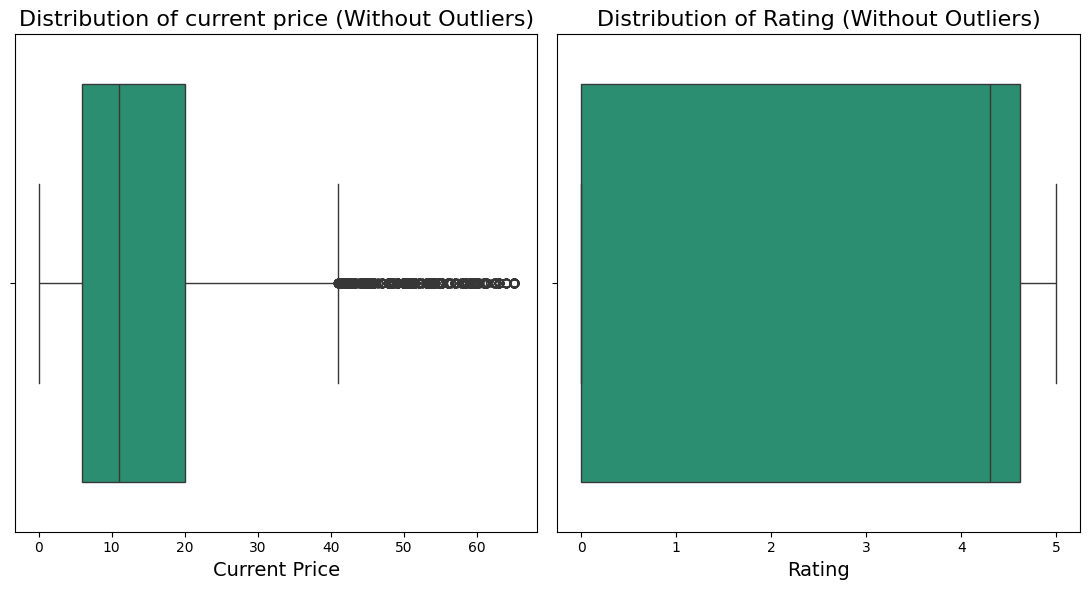

In [137]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

filtered_df = df.copy()
for col in ['current_price', 'Rating']:
    filtered_df = remove_outliers(filtered_df, col)

plt.figure(figsize=(11, 6))
for j, i in enumerate(['current_price', 'Rating']):
    plt.subplot(1, 2, j + 1)
    sns.boxplot(data=filtered_df, x=i, palette="Dark2")
    plt.title(f'Distribution of {i.replace("_", " ")} (Without Outliers)', fontsize=16)
    plt.xlabel(i.replace("_", " ").title(), fontsize=14)

plt.tight_layout()
plt.show()

#### The boxplots visually demonstrates the effectiveness of the outlier removal process. The outliers that were previously present in the original data are no longer visible in the filtered data.

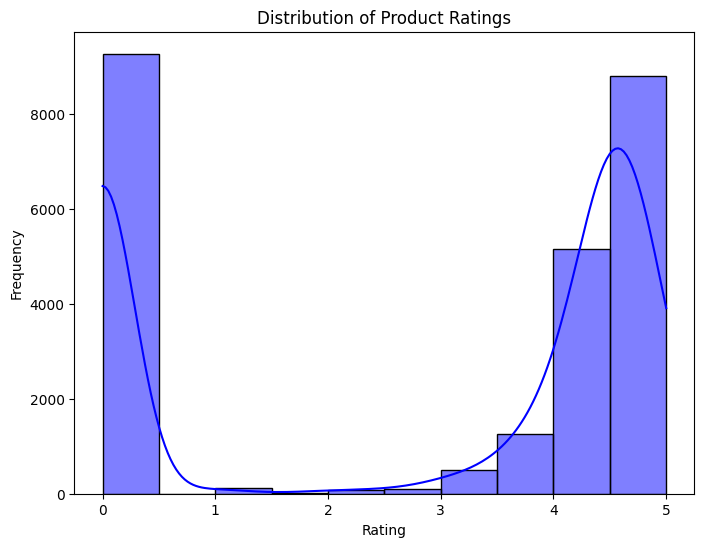

In [138]:
#Distribution of Ratings

plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], kde=True, bins=10, color='blue')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

- The bimodal nature suggests that there might be two distinct groups of customers with different preferences or expectations. One group may be highly satisfied, while the other may be less satisfied.

- The concentration of ratings at the extremes indicates that customers tend to have strong opinions about the product, either positive or negative.

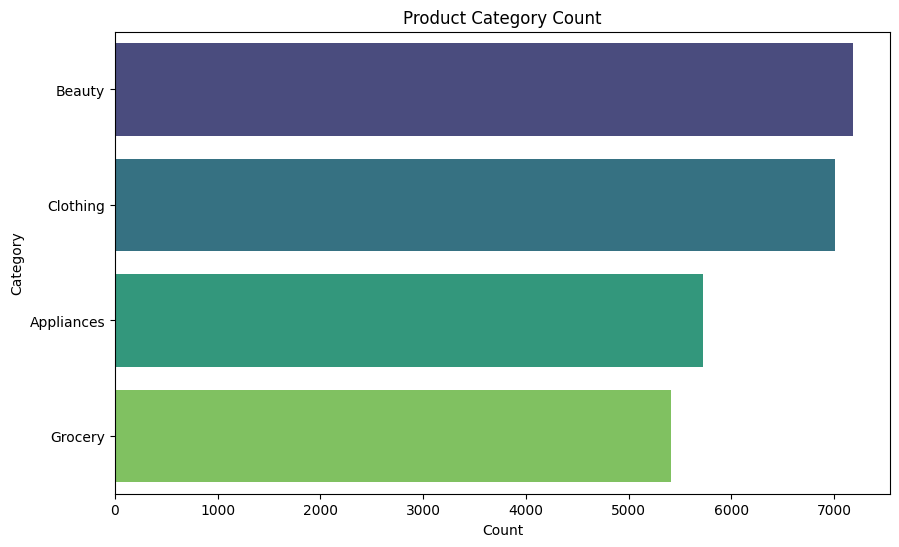

In [139]:
#Category Count

plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df, palette='viridis', order=df['Category'].value_counts().index)
plt.title('Product Category Count')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

- The high count for Beauty and Clothing suggests that customers have a strong preference for these categories. This could be due to various factors like fashion trends, personal care needs, and lifestyle choices.

- Appliances and Grocery have significantly fewer products compared to the top two categories.


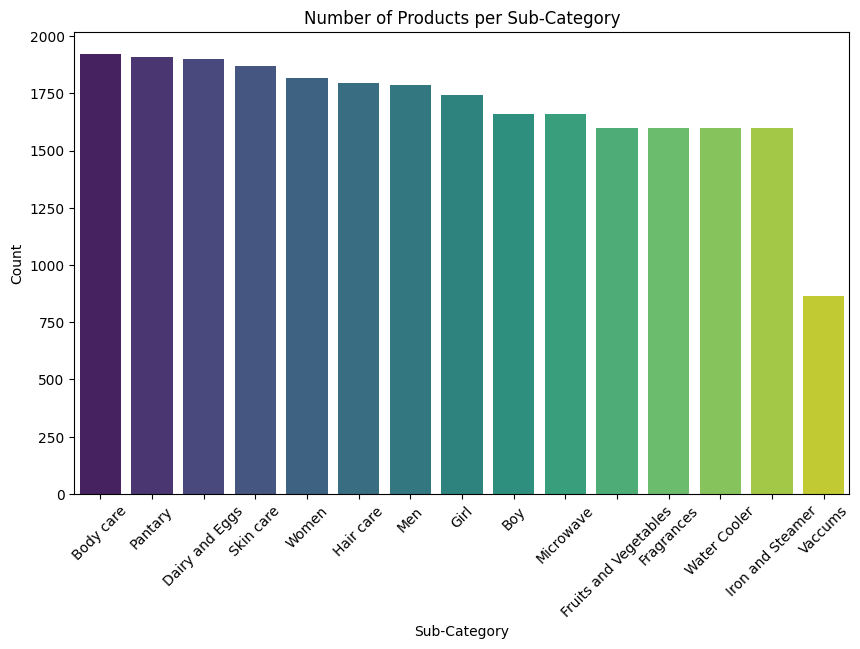

In [140]:
# Count of Products in Each Sub-Category
sub_category_count = df['Sub_category'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sub_category_count.index, y=sub_category_count.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Number of Products per Sub-Category')
plt.ylabel('Count')
plt.xlabel('Sub-Category')
plt.show()

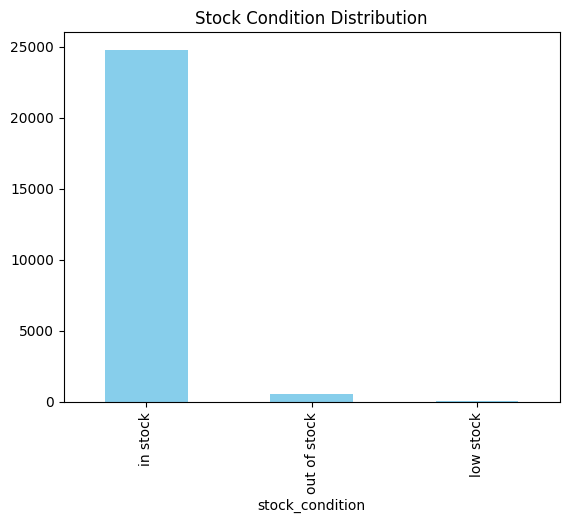

In [141]:
# Stock condition Analysis

stock_analysis = df['stock_condition'].value_counts()
stock_analysis.plot(kind='bar', color='skyblue', title='Stock Condition Distribution')
plt.show()

- The high number of in-stock products indicates that the retailer has effective inventory management practices.

- Strong relationships with suppliers contributes to timely replenishment of stock.

## Bivariate Analysis

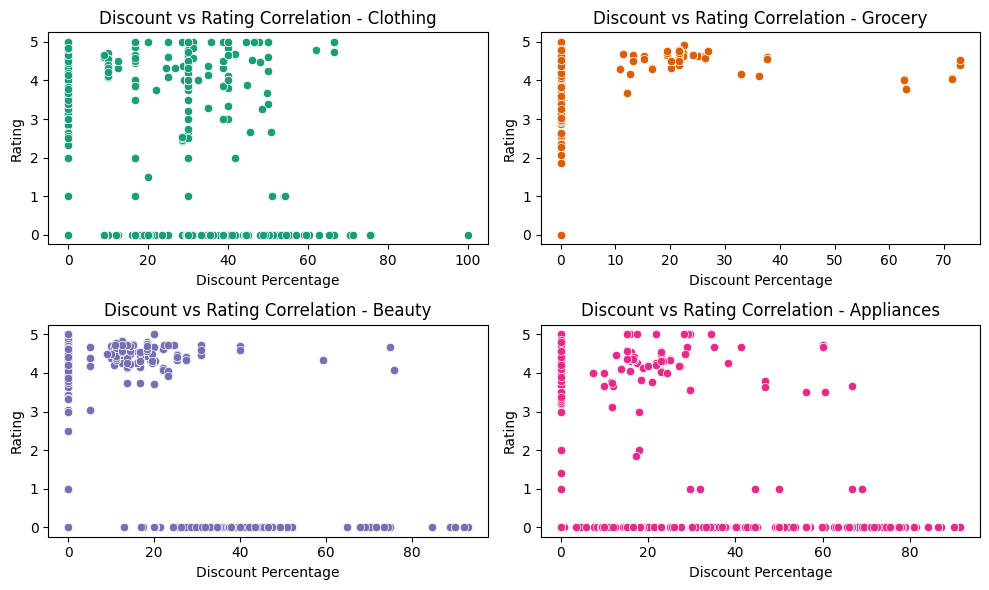

In [142]:
#Looping through unique categories and created individual scatter plots

palette = sns.color_palette("Dark2", len(df['Category'].unique()))
plt.figure(figsize=(10, 6))
categories = df['Category'].unique()
for i, category in enumerate(categories):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(
        data=df[df['Category'] == category],
        x='discount_percentage',
        y='Rating',
        color=palette[i]
    )
    plt.title(f"Discount vs Rating Correlation - {category}")
    plt.xlabel("Discount Percentage")
    plt.ylabel("Rating")

plt.tight_layout()
plt.show()

- Across all four categories (Clothing, Grocery, Beauty, and Appliances), there doesn't appear to be a strong,
  linear correlation between discount percentage and product rating.

- Factors like product quality, brand reputation, and customer expectations have a stronger impact on ratings than discounts.

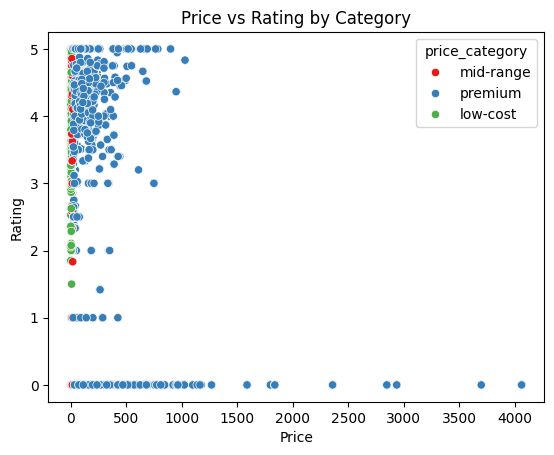

In [143]:
# Price vs Rating

sns.scatterplot(data=df, x='current_price', y='Rating', hue='price_category', palette='Set1')
plt.title('Price vs Rating by Category')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()


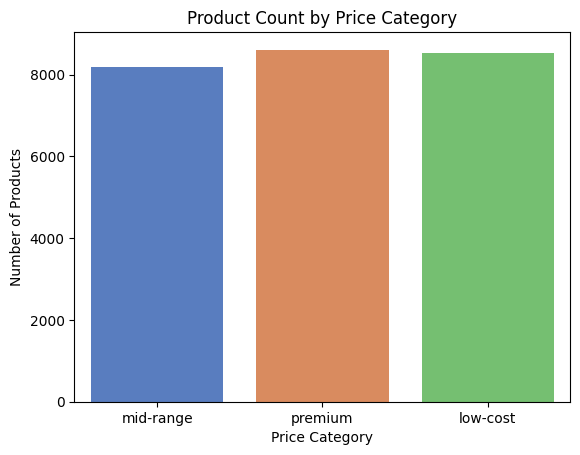

In [144]:
# Product Count Vs Price Category
sns.countplot(data=df, x='price_category', palette='muted')
plt.title('Product Count by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Number of Products')
plt.show()

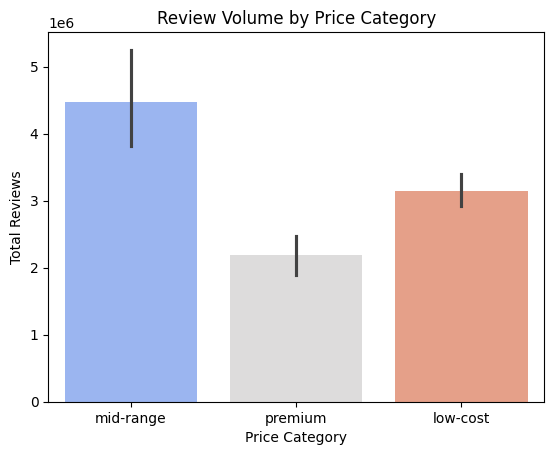

In [145]:
# Review Volume by Category

sns.barplot(data=df, x='price_category', y='Review', estimator=np.sum, palette='coolwarm')
plt.title('Review Volume by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Total Reviews')
plt.show()

## Multivariate Analysis

In [146]:
df.columns

Index(['website', 'country', 'Category', 'Sub_category', 'usItemId',
       'product_name', 'brand', 'breadcrum', 'product_url', 'current_price',
       'original_price', 'discount', 'unit_price', 'stock_condition',
       'canAddToCart', 'subscriptionEligible', 'isSponsoredFlag',
       'fulfillmentBadges', 'returnable', 'returnable_period',
       'returnable_period_type', 'badges', 'Rating', 'Review', 'sellerName',
       'isPreOrder', 'manufacturerName', 'datetime', 'discount_percentage',
       'month', 'day_of_week', 'price_category', 'high_demand'],
      dtype='object')

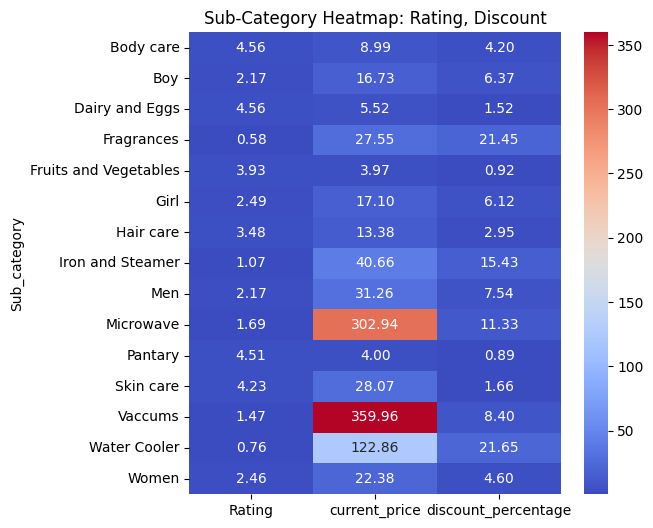

In [147]:
# Create a pivot table
heatmap_data = df.pivot_table(index='Sub_category', values=['Rating', 'discount_percentage', 'current_price'], aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Sub-Category Heatmap: Rating, Discount')
plt.show()

- Fragrances, Water Cooler, and Vaccums: These sub-categories have relatively low average ratings but offer high discounts.
  This suggests that customers are less satisfied with these products, and discounts are being used to incentivize purchases.

- Sub-categories with higher ratings have better product quality, customer service, or brand reputation.

### **Advanced EDA Methods:**

#### ***Pareto Analysis (80/20 Rule):***

**The Pareto chart illustrates the "80-20 rule" in action, showing which categories contribute the majority of the total discount percentage, showing promotional effort.**


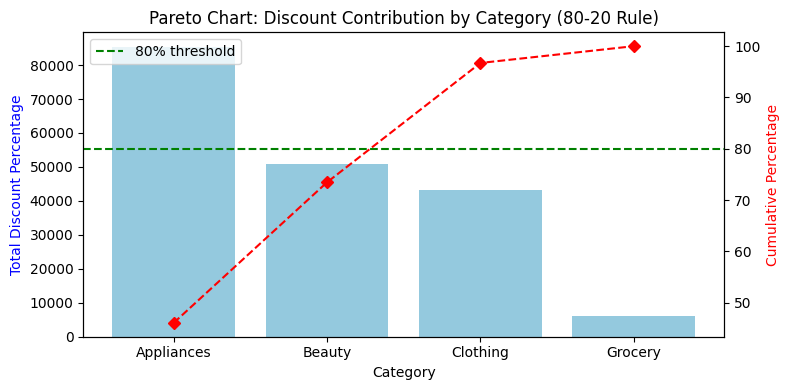

In [148]:
# Group by Category and calculating total discount percentage
category_discounts = df.groupby('Category')['discount_percentage'].sum().sort_values(ascending=False)

# Calculating cumulative percentage
category_discounts_cum = category_discounts.cumsum() / category_discounts.sum() * 100

#Pareto chart
fig, ax1 = plt.subplots(figsize=(8, 4))

# Bar chart for discount percentage by category
sns.barplot(x=category_discounts.index, y=category_discounts.values, ax=ax1, color='skyblue')
ax1.set_ylabel('Total Discount Percentage', color='blue')
ax1.set_xlabel('Category')

# Secondary y-axis for the cumulative percentage line
ax2 = ax1.twinx()
ax2.plot(category_discounts_cum.index, category_discounts_cum.values, color='red', marker='D', linestyle='--')
ax2.set_ylabel('Cumulative Percentage', color='red')

# Highlighting the 80% line on the cumulative chart
ax2.axhline(80, color='green', linestyle='--', label='80% threshold')

#Chart
plt.title("Pareto Chart: Discount Contribution by Category (80-20 Rule)")
ax2.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Observations:**
1. **Appliances are Dominant**: The "Appliances" category accounts for the majority of the total discount %. It accounts for more than 80% of all discounts.
2. **80% Threshold**: The green dashed line indicates the 80% threshold. The category "Appliances" surpasses this threshold, highlighting its significance.

**Potential Insights and Recommendations:**
1. Since **Appliances** drive the majority of discounts, it may be worth exploring strategies to optimize discounts in this category. This could involve analyzing **customer behavior, competitor pricing, and promotional effectiveness**.
2. The lesser contribution of Beauty, Clothing, and Grocery shows that their discount practices should be examined more closely. Consider if these categories are **under-discounted** or whether there is space for improvement without affecting total revenue.

## **Advanced Machine Learning Analysis**

### **Product Segmentation using Clustering**:

In [149]:
#Using K-Means Clustering

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Select numerical features for clustering
cluster_features = ['Rating', 'discount_percentage', 'current_price', 'Review']

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[cluster_features])

# Find the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

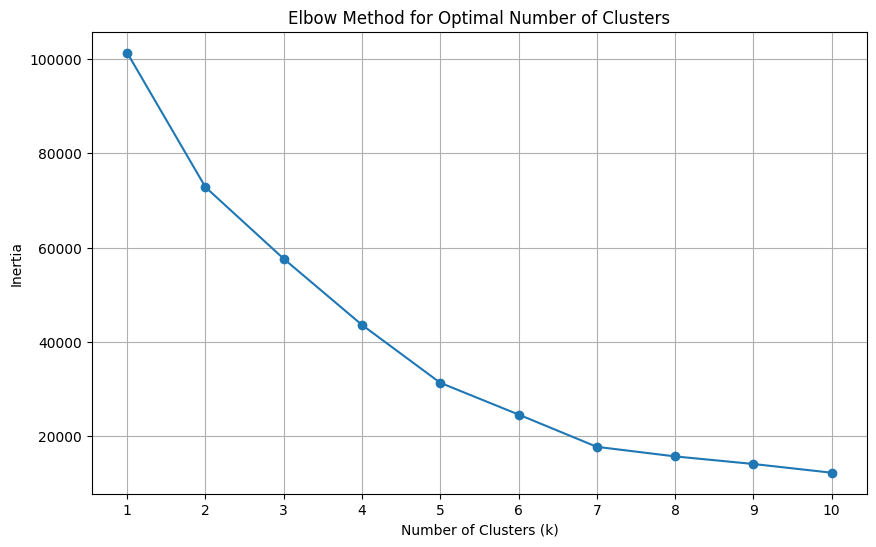

In [150]:
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid()
plt.show()

In [151]:
# Optimal number of clusters (Based on the elbow curve)

optimal_k = 4

# Fitting K-Means with optimal number of clusters

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Analyze the clusters
print(df.groupby('cluster')[cluster_features].mean())



           Rating  discount_percentage  current_price        Review
cluster                                                            
0        4.445005             2.502721      31.960662    414.848428
1        0.037562             3.269724     112.742653      2.351994
2        0.435481            49.979695      30.611065     11.039576
3        4.602349             2.385951      18.943860  29212.508772


In [152]:
df[cluster_features].describe()

,Rating,discount_percentage,current_price,Review
count,25326.000000,25326.000000,25326.000000,25326.000000
mean,2.792493,7.317096,54.960477,386.985706
std,2.167533,16.362048,173.499524,2587.550420
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,6.570000,0.000000
50%,4.207300,0.000000,13.470000,8.000000
75%,4.600000,0.000000,29.970000,136.000000
max,5.000000,100.000000,4063.290000,101043.000000


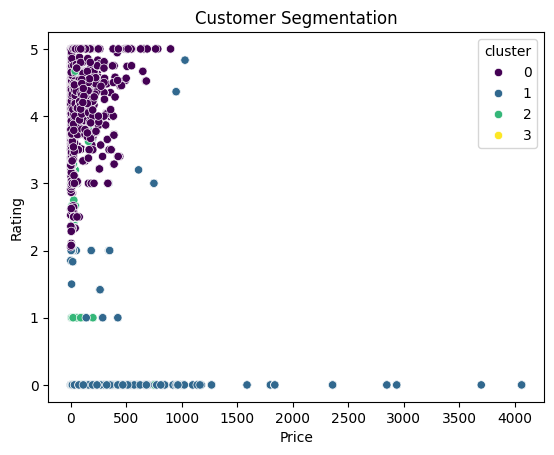

In [153]:
sns.scatterplot(data=df, x='current_price', y='Rating', hue='cluster', palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()

## **Predictive Analytics:**

### **Product Churn Prediction:**

In [154]:
df.columns

Index(['website', 'country', 'Category', 'Sub_category', 'usItemId',
       'product_name', 'brand', 'breadcrum', 'product_url', 'current_price',
       'original_price', 'discount', 'unit_price', 'stock_condition',
       'canAddToCart', 'subscriptionEligible', 'isSponsoredFlag',
       'fulfillmentBadges', 'returnable', 'returnable_period',
       'returnable_period_type', 'badges', 'Rating', 'Review', 'sellerName',
       'isPreOrder', 'manufacturerName', 'datetime', 'discount_percentage',
       'month', 'day_of_week', 'price_category', 'high_demand', 'cluster'],
      dtype='object')

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE


# Churn Indicator: Identifying products with low ratings or can be frequently returned:

df['churn'] = (df['Rating'] < 3) | (df['returnable'] & (df['returnable_period'] < 30))

# Ensuring no leakage in features

df['stock_condition'] = df['stock_condition'].astype('category').cat.codes
features = ['Review', 'discount_percentage', 'stock_condition']

X = df[features]
y = df['churn']

# Addressed class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Training Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', random_state=42)

lr_model.fit(X_train, y_train)

# Predictions
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.68      0.80      3152
        True       0.75      0.98      0.85      3135

    accuracy                           0.83      6287
   macro avg       0.86      0.83      0.82      6287
weighted avg       0.86      0.83      0.82      6287



In [156]:
df['churn'].value_counts()

churn
False    15716
True      9610
Name: count, dtype: int64

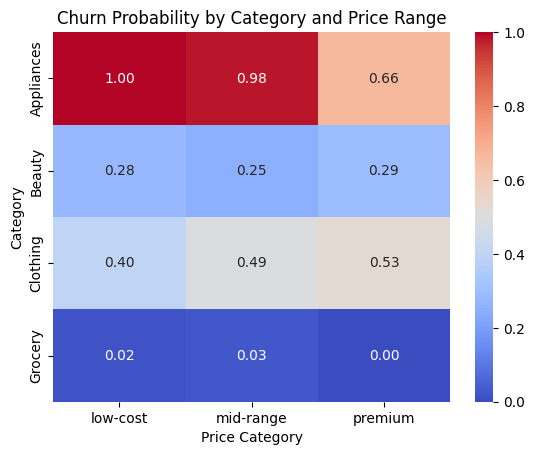

In [157]:
# Heatmap for churn

churn_pivot = df.pivot_table(index='Category', columns='price_category', values='churn', aggfunc='mean')
sns.heatmap(churn_pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Churn Probability by Category and Price Range')
plt.xlabel('Price Category')
plt.ylabel('Category')
plt.show()


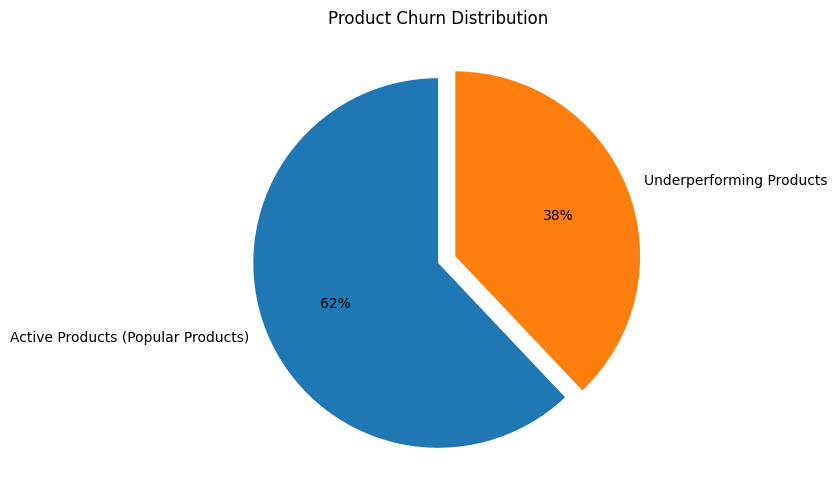

In [158]:
# Product Churn Distribution Visualization

labels = ['Active Products (Popular Products)', 'Underperforming Products']
values = df['churn'].value_counts().values.tolist()
palette_color = sns.color_palette('tab10')

plt.figure(figsize=(8, 6))
plt.pie(
    values,
    labels=labels,
    colors=palette_color,
    autopct='%.0f%%',
    startangle=90,
    explode=(0, 0.1)  # Highlighting 'Products Churned'
)
plt.title('Product Churn Distribution')
plt.show()

## **Product Lifetime Value (PLV)**  

##### Product Lifetime Value (PLTV) is a metric that measures the total revenue a company can expect to generate from a single product over its entire lifecycle.

##### It's a crucial metric for businesses as it helps assess the long-term value of each product and make informed decisions about product acquisition, retention, and upselling strategies.

**Revenue:**

Revenue=
current_price
×
Review

**Discount Effectiveness:**

Discount Effectiveness=
(original_price
−
current_price)/
original_price

**Retention:** Assumed products with higher ratings (Rating > 3.5) have better retention.

**Time on Market:** Calculate the days since the product was listed.

In [167]:
df['revenue'] = df['current_price'] * df['Review']  # Approximation using price and reviews
df['discount_effectiveness'] = (df['original_price'] - df['current_price']) / df['original_price']

mean_value = df['discount_effectiveness'].mean()

# Replaced NaN values with the calculated mean
df['discount_effectiveness'].fillna(mean_value, inplace=True)


# Assigned retention probabilities based on rating
df['retention'] = np.where(df['Rating'] > 3.5, 0.9, 0.5)  #90% retention for higher-rated products

# Calculate PLV
df['plv'] = df['revenue'] * df['retention'] * (1 - df['discount_effectiveness'])


In [168]:
top_products = df[['brand', 'Category', 'plv']].sort_values(by='plv', ascending=False).head(10)
top_products

,brand,Category,plv
17897,Olay,Beauty,1224944.289
14845,Olay,Beauty,1224944.289
21056,Olay,Beauty,1224944.289
24301,Olay,Beauty,1224944.289
11626,Olay,Beauty,1224944.289
2280,Olay,Beauty,1224580.599
8511,Olay,Beauty,1224580.599
8480,Olay,Beauty,667734.840
21144,Olay,Beauty,667734.840
24390,Olay,Beauty,667734.840


In [169]:
subcat_plv = df.groupby('Sub_category')['plv'].mean().sort_values(ascending=False)
subcat_plv

Sub_category
Body care                28500.138784
Skin care                26516.788706
Water Cooler              9799.965210
Microwave                 6744.531029
Fragrances                4929.197946
Hair care                 2462.610653
Pantary                   1599.462120
Iron and Steamer          1428.795388
Fruits and Vegetables     1287.866412
Dairy and Eggs            1164.017083
Men                        865.294251
Vaccums                    678.515125
Women                      531.666754
Boy                         75.019927
Girl                        67.770874
Name: plv, dtype: float64

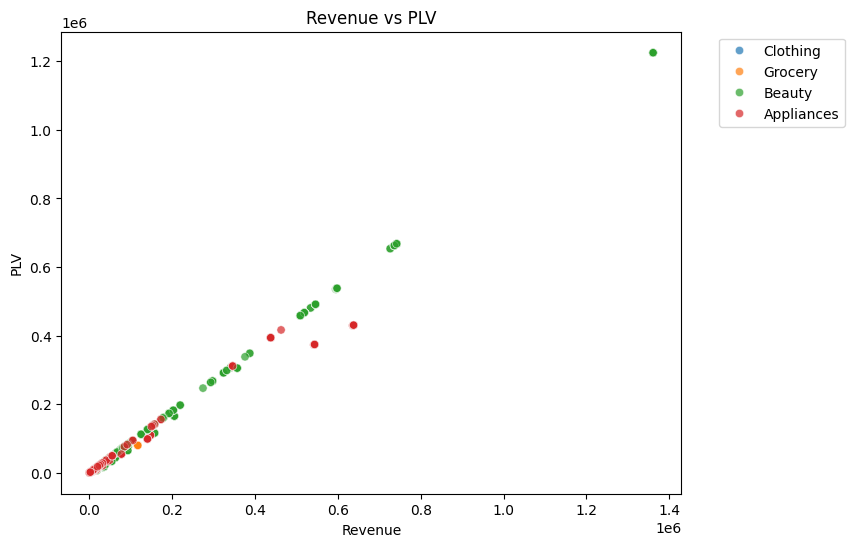

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='revenue', y='plv', hue='Category', alpha=0.7)
plt.title('Revenue vs PLV')
plt.xlabel('Revenue')
plt.ylabel('PLV')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## **SWOT Analysis:**

### **Strengths: High-Performing Categories/Products**

In [163]:
high_performers = df[(df['Rating'] > 4) & (df['Review'] > df['Review'].mean())]

# Aggregate performance at the category and product levels

high_performing_categories = high_performers.groupby('Category').agg({
    'current_price': 'sum',  # Total revenue
    'Rating': 'mean',        # Average rating
    'Review': 'sum'          # Total reviews
}).reset_index().sort_values(by='current_price', ascending=False)

high_performing_products = high_performers.groupby('product_name').agg({
    'current_price': 'sum',
    'Rating': 'mean',
    'Review': 'sum'
}).reset_index().sort_values(by='current_price', ascending=False)

print("High-Performing Categories:")
print(high_performing_categories.head(10))

print("\nHigh-Performing Products:")
print(high_performing_products.head(10))


High-Performing Categories:
     Category  current_price    Rating   Review
1      Beauty       39290.23  4.579720  7079517
0  Appliances       17400.75  4.306090   164496
3     Grocery        4326.63  4.491923   942171
2    Clothing        2214.11  4.442112    76313

High-Performing Products:
                                          product_name  current_price  \
8    Avalon A5BLK Self Cleaning Bottleless Water Co...        3933.60   
334     Primo Single Serve Bottom Load Water Dispenser        2399.84   
5    Absolue Revitalizing Brightening Soft Cream by...        1720.00   
53   Carolina Herrera Good Girl EDP Supreme For Her...        1534.67   
333  Primo Deluxe Top Load Bottled Water Dispenser,...        1439.84   
183  Hamilton Beach 1.1 cu.ft. Stainless Steel Micr...        1039.84   
131  Galanz 0.9 cu.ft. 3 in 1 Airfry Microwave, Sta...        1039.76   
340  Revitalift Triple Power LZR Retinol Anti-Aging...         978.67   
62   CeraVe Moisturizing Cream with 3 Ceramides 

### **Weaknesses: Low-Rated Products**

In [164]:
low_rated_products = df[df['Rating'] < 3]

# Checking products frequently marked as returnable with a short return period

frequently_returned = df[df['returnable'] & (df['returnable_period'] < 30)]

print("Low-Rated Products:")
print(low_rated_products[['product_name', 'brand', 'Category', 'Rating', 'Review']].head(10))

Low-Rated Products:
                                         product_name               brand  \
3   George Plus Women's Plush Sleep Pant, Sizes 1X-4X              George   
10  George Plus Women's Plush Sleep jogger, Sizes ...              George   
11    George Women's Plush Sleep jogger, Sizes XS-XXL              George   
12                    George Plus Women's Pajama Pant              George   
18    George Plus Women's Peached Jogger, Sizes 1X-4X              George   
21  George Plus Women's Scoop Neckline Tee, Sizes ...              George   
27  Mountain Warehouse Snowdon Women's Fleece Top ...  Mountain Warehouse   
28  Mountain Warehouse Women Snuggle Hoodie Ladies...  Mountain Warehouse   
48           George Women's Velour Pajama 2-Piece Set              George   
52  WIFORNT Women Denim Long Jumpsuit Casual Spagh...             WIFORNT   

    Category  Rating  Review  
3   Clothing  0.0000       0  
10  Clothing  0.0000       0  
11  Clothing  0.0000       0  
12  Clot

### **Opportunities: High Discounts but Low Reviews**

In [165]:
opportunities = df[(df['discount'] > 30) & (df['Review'] < df['Review'].mean())]

# Grouped by Category or Sub-category to identify opportunities
opportunity_categories = opportunities.groupby('Category').agg({
    'discount': 'mean',
    'Review': 'mean',
    'current_price': 'sum'
}).reset_index().sort_values(by='current_price', ascending=False)

print("Categories with Untapped Potential (High Discounts, Low Reviews):")
print(opportunity_categories.head(10))


Categories with Untapped Potential (High Discounts, Low Reviews):
     Category    discount    Review  current_price
0  Appliances  120.436486  5.741742      371777.59
1    Clothing   59.401579  1.000000        7253.89


### **Threats: Stockouts or Negative Feedback**

In [166]:
# Products with high reviews but low ratings (negative feedback)
negative_feedback_products = df[(df['Review'] > df['Review'].mean()) & (df['Rating'] < 3)]


print("\nProducts with Negative Feedback:")
print(negative_feedback_products[['product_name', 'brand', 'Category', 'Rating', 'Review']].head(10))



Products with Negative Feedback:
                                         product_name               brand  \
1174    Tomato, Roma, Sold in singles, 0.10 - 0.14 kg              Others   
1229      Red Onions, Sold in singles, 0.16 - 0.30 kg  Peak of the Market   
1296  Potato, Russet, Sold in singles, 0.24 - 0.42 kg              Others   
4231    Tomato, Roma, Sold in singles, 0.10 - 0.14 kg              Others   
4281      Red Onions, Sold in singles, 0.16 - 0.30 kg  Peak of the Market   
4351  Potato, Russet, Sold in singles, 0.24 - 0.42 kg              Others   
4419           Grapefruit, Large Red, Sold in singles              Others   
7397    Tomato, Roma, Sold in singles, 0.10 - 0.14 kg              Others   
7453      Red Onions, Sold in singles, 0.16 - 0.30 kg  Peak of the Market   
7521  Potato, Russet, Sold in singles, 0.24 - 0.42 kg              Others   

     Category  Rating  Review  
1174  Grocery  2.5222    4973  
1229  Grocery  2.3522    2121  
1296  Grocery  1.8484 